In [7]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
import itertools 
import shap
import matplotlib.pyplot as plt

In [154]:
input_df = pd.read_csv('./diabetes_data.csv')
input_df.describe()

,times_pregnant,glucose_conc,diastolic_blood_pressure,triceps_skin_thickness,2hr_insulin,bmi,pedigree_function,age,label
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [155]:
input_df.corr(method='pearson')

,times_pregnant,glucose_conc,diastolic_blood_pressure,triceps_skin_thickness,2hr_insulin,bmi,pedigree_function,age,label
times_pregnant,1.000000,0.129459,0.141282,-0.081672,-0.073535,0.017683,-0.033523,0.544341,0.221898
glucose_conc,0.129459,1.000000,0.152590,0.057328,0.331357,0.221071,0.137337,0.263514,0.466581
diastolic_blood_pressure,0.141282,0.152590,1.000000,0.207371,0.088933,0.281805,0.041265,0.239528,0.065068
triceps_skin_thickness,-0.081672,0.057328,0.207371,1.000000,0.436783,0.392573,0.183928,-0.113970,0.074752
2hr_insulin,-0.073535,0.331357,0.088933,0.436783,1.000000,0.197859,0.185071,-0.042163,0.130548
bmi,0.017683,0.221071,0.281805,0.392573,0.197859,1.000000,0.140647,0.036242,0.292695
pedigree_function,-0.033523,0.137337,0.041265,0.183928,0.185071,0.140647,1.000000,0.033561,0.173844
age,0.544341,0.263514,0.239528,-0.113970,-0.042163,0.036242,0.033561,1.000000,0.238356
label,0.221898,0.466581,0.065068,0.074752,0.130548,0.292695,0.173844,0.238356,1.000000


In [156]:
def count_rows_with_bad_data(X):
    total_rows = len(X)
    column_names = list(X.columns.values)
    
    for column_name in column_names:
        if column_name != 'label':
            zero_values = len(X[X[column_name] == 0]) * 100.0 / total_rows
            print(f"Percentage of rows with zero {column_name} : {zero_values} %")

In [157]:
count_rows_with_bad_data(input_df)

Percentage of rows with zero times_pregnant : 14.453125 %
Percentage of rows with zero glucose_conc : 0.6510416666666666 %
Percentage of rows with zero diastolic_blood_pressure : 4.557291666666667 %
Percentage of rows with zero triceps_skin_thickness : 29.557291666666668 %
Percentage of rows with zero 2hr_insulin : 48.697916666666664 %
Percentage of rows with zero bmi : 1.4322916666666667 %
Percentage of rows with zero pedigree_function : 0.0 %
Percentage of rows with zero age : 0.0 %


In [158]:
#input_dropped = input_df.drop(labels={'2hr_insulin'}, axis=1)
input_dropped = input_df

In [159]:
# Separate the features and the labels in X and y
X = input_dropped.iloc[:, :-1]
y = input_dropped.iloc[:, -1:]

In [160]:
X.head()

,times_pregnant,glucose_conc,diastolic_blood_pressure,triceps_skin_thickness,2hr_insulin,bmi,pedigree_function,age
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33


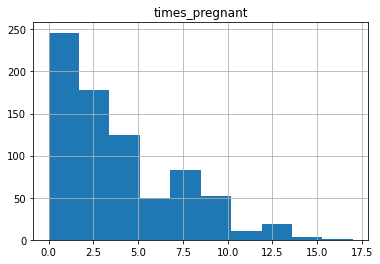

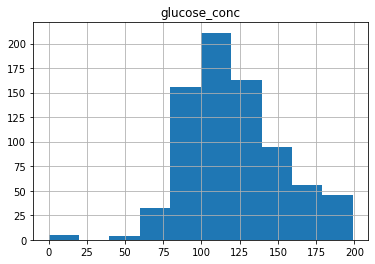

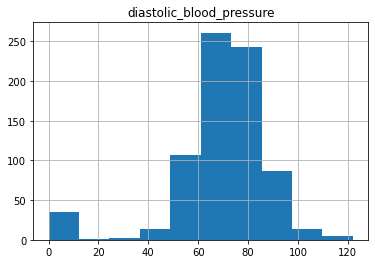

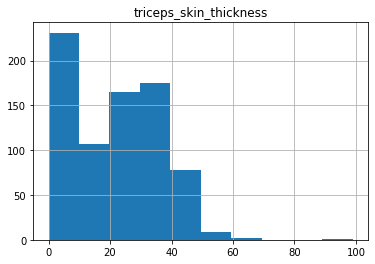

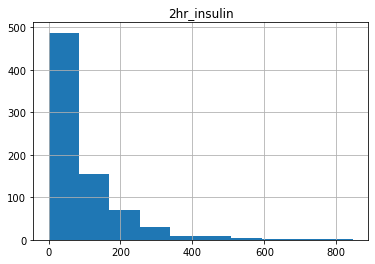

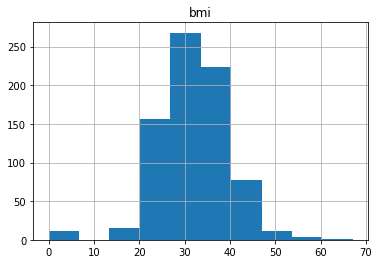

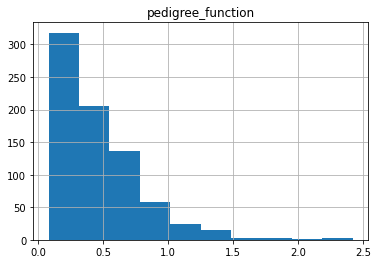

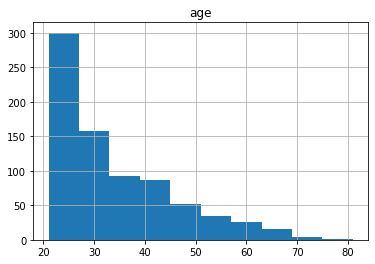

In [161]:
for col in X.columns:
    input_dropped[col].hist()
    plt.title(col)
    plt.show()

In [162]:
def get_glucose_conc_range(val):
    if val > 125:
        return 'greater_than_125'
    elif val > 100:
        return 'between_100_and_125'
    elif val > 70:
        return 'between_70_and_100'
    else:
        return 'less_than_equal_70'

In [163]:
def get_diastolic_bp_range(val):
    if val > 80:
        return 'greater_than_80'
    elif val >= 60:
        return 'between_60_and_80'
    else:
        return 'less_than_60'

In [164]:
non_zero_2hr_insulin_count = len(X[X['2hr_insulin'] > 0])
sum_2hr_insulin_count = X['2hr_insulin'].sum()

mean_non_zero_2hr_insulin = 1.0 * sum_2hr_insulin_count / non_zero_2hr_insulin_count
print(f"Mean non-zero 2 hour insulin : {mean_non_zero_2hr_insulin}")

Mean non-zero 2 hour insulin : 155.5482233502538


In [165]:
X['glucose_range'] = X['glucose_conc'].apply(lambda x : get_glucose_conc_range(x))
X['diastolic_bp_range'] = X['diastolic_blood_pressure'].apply(lambda x : get_diastolic_bp_range(x))
X['imputed_2hr_insulin'] = X['2hr_insulin'].apply(lambda x : x if (x > 0) else mean_non_zero_2hr_insulin)

In [166]:
def one_hot_encode(df, categorical_features):
    """ One hot encode the categorical features """
    dum_df = pd.get_dummies(df, columns=categorical_features, prefix_sep = '=', sparse=False, drop_first=False)
    return dum_df

In [167]:
categorical_features = ['glucose_range', 'diastolic_bp_range']
X_encoded = one_hot_encode(X, categorical_features)
#X = X_encoded.drop(['bmi', 'glucose_conc', 'diastolic_blood_pressure'], axis=1)
X = X_encoded.drop(['2hr_insulin'], axis=1)
#X = X_encoded

In [168]:
X.head()

,times_pregnant,glucose_conc,diastolic_blood_pressure,triceps_skin_thickness,bmi,pedigree_function,age,imputed_2hr_insulin,glucose_range=between_100_and_125,glucose_range=between_70_and_100,glucose_range=greater_than_125,glucose_range=less_than_equal_70,diastolic_bp_range=between_60_and_80,diastolic_bp_range=greater_than_80,diastolic_bp_range=less_than_60
0,6,148,72,35,33.6,0.627,50,155.548223,0,0,1,0,1,0,0
1,1,85,66,29,26.6,0.351,31,155.548223,0,1,0,0,1,0,0
2,8,183,64,0,23.3,0.672,32,155.548223,0,0,1,0,1,0,0
3,1,89,66,23,28.1,0.167,21,94.000000,0,1,0,0,1,0,0
4,0,137,40,35,43.1,2.288,33,168.000000,0,0,1,0,0,0,1


In [169]:
X.shape

(768, 15)

In [170]:
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.20, random_state=10)

In [171]:
def holdout_grid_search(clf, X_train, y_train, X_test, y_test, hyperparams, fixed_hyperparams={}):
    best_estimator = None 
    best_hyperparams = {}
    
    best_score = 0.0
    
    # get list of param values
    lists = hyperparams.values()
    # get all param combinations names to values in best_estimator
    param_combinations = list(itertools.product(*lists))
    total_param_combinations = len(param_combinations)
    
    # iterate through param combinations
    for i, params in enumerate(param_combinations, 1):
        # fill param dict with params
        param_dict = {}
        for param_index, param_name in enumerate(hyperparams):
            param_dict[param_name] = params[param_index]
        
        # create estimator with specified params
        estimator = clf(**param_dict, **fixed_hyperparams)
    
        # fit estimator
        estimator.fit(X_train, y_train)
        # get predictions on the test
        y_preds = estimator.predict(X_test)
        f1score = f1_score(y_test, y_preds)
    
        print(f'[{i}/{total_param_combinations}] {param_dict}')
        print(f'Val f1-score: {f1score}\n')
    
        if f1score >= best_score:
            best_score = f1score
            best_estimator = estimator
            best_hyperparams = param_dict
        
    best_hyperparams.update(fixed_hyperparams)
    
    return best_estimator, best_hyperparams


In [178]:
def random_forest_grid_search(X_train, y_train, X_test, y_test):
    hyperparams = {
        'n_estimators': [50, 75, 100, 110],
        'max_depth': [1,2,3,4,5],
        'min_samples_leaf': [1,2,3,4,5,6,7,8,9,10]
    }
    fixed_hyperparams = {
       'random_state': 10,
    }
    
    rf = RandomForestClassifier
    
    best_rf, best_hyperparams = holdout_grid_search(rf, X_train, y_train, X_test, y_test, hyperparams, fixed_hyperparams)
    
    print(f"Best hyperparameters:\n{best_hyperparams}")
    
    y_train_best_pred = best_rf.predict(X_train)
    print("Train f1 score : " + str(f1_score(y_train, y_train_best_pred)))
    
    y_test_best_pred = best_rf.predict(X_test)
    print("Test f1 score : " + str(f1_score(y_test, y_test_best_pred)))
    
    return best_rf

In [179]:
best_rf = random_forest_grid_search(X_dev, y_dev, X_test, y_test)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[1/200] {'n_estimators': 50, 'max_depth': 1, 'min_samples_leaf': 1}
Val f1-score: 0.2352941176470588

[2/200] {'n_estimators': 50, 'max_depth': 1, 'min_samples_leaf': 2}
Val f1-score: 0.2352941176470588

[3/200] {'n_estimators': 50, 'max_depth': 1, 'min_samples_leaf': 3}
Val f1-score: 0.2352941176470588

[4/200] {'n_estimators': 50, 'max_depth': 1, 'min_samples_leaf': 4}
Val f1-score: 0.2352941176470588



A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[5/200] {'n_estimators': 50, 'max_depth': 1, 'min_samples_leaf': 5}
Val f1-score: 0.2352941176470588

[6/200] {'n_estimators': 50, 'max_depth': 1, 'min_samples_leaf': 6}
Val f1-score: 0.2352941176470588

[7/200] {'n_estimators': 50, 'max_depth': 1, 'min_samples_leaf': 7}
Val f1-score: 0.2352941176470588

[8/200] {'n_estimators': 50, 'max_depth': 1, 'min_samples_leaf': 8}
Val f1-score: 0.2352941176470588



A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[9/200] {'n_estimators': 50, 'max_depth': 1, 'min_samples_leaf': 9}
Val f1-score: 0.2352941176470588

[10/200] {'n_estimators': 50, 'max_depth': 1, 'min_samples_leaf': 10}
Val f1-score: 0.2352941176470588

[11/200] {'n_estimators': 50, 'max_depth': 2, 'min_samples_leaf': 1}
Val f1-score: 0.5287356321839081



A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[12/200] {'n_estimators': 50, 'max_depth': 2, 'min_samples_leaf': 2}
Val f1-score: 0.5287356321839081

[13/200] {'n_estimators': 50, 'max_depth': 2, 'min_samples_leaf': 3}
Val f1-score: 0.5287356321839081

[14/200] {'n_estimators': 50, 'max_depth': 2, 'min_samples_leaf': 4}
Val f1-score: 0.5287356321839081

[15/200] {'n_estimators': 50, 'max_depth': 2, 'min_samples_leaf': 5}
Val f1-score: 0.5287356321839081



A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[16/200] {'n_estimators': 50, 'max_depth': 2, 'min_samples_leaf': 6}
Val f1-score: 0.5116279069767442

[17/200] {'n_estimators': 50, 'max_depth': 2, 'min_samples_leaf': 7}
Val f1-score: 0.5116279069767442

[18/200] {'n_estimators': 50, 'max_depth': 2, 'min_samples_leaf': 8}
Val f1-score: 0.5116279069767442

[19/200] {'n_estimators': 50, 'max_depth': 2, 'min_samples_leaf': 9}
Val f1-score: 0.5287356321839081



A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[20/200] {'n_estimators': 50, 'max_depth': 2, 'min_samples_leaf': 10}
Val f1-score: 0.5287356321839081

[21/200] {'n_estimators': 50, 'max_depth': 3, 'min_samples_leaf': 1}
Val f1-score: 0.5360824742268041

[22/200] {'n_estimators': 50, 'max_depth': 3, 'min_samples_leaf': 2}
Val f1-score: 0.5473684210526315

[23/200] {'n_estimators': 50, 'max_depth': 3, 'min_samples_leaf': 3}
Val f1-score: 0.5473684210526315



A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[24/200] {'n_estimators': 50, 'max_depth': 3, 'min_samples_leaf': 4}
Val f1-score: 0.5473684210526315

[25/200] {'n_estimators': 50, 'max_depth': 3, 'min_samples_leaf': 5}
Val f1-score: 0.5473684210526315

[26/200] {'n_estimators': 50, 'max_depth': 3, 'min_samples_leaf': 6}
Val f1-score: 0.5473684210526315

[27/200] {'n_estimators': 50, 'max_depth': 3, 'min_samples_leaf': 7}
Val f1-score: 0.5567010309278351



A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[28/200] {'n_estimators': 50, 'max_depth': 3, 'min_samples_leaf': 8}
Val f1-score: 0.5416666666666666

[29/200] {'n_estimators': 50, 'max_depth': 3, 'min_samples_leaf': 9}
Val f1-score: 0.5473684210526315

[30/200] {'n_estimators': 50, 'max_depth': 3, 'min_samples_leaf': 10}
Val f1-score: 0.5416666666666666

[31/200] {'n_estimators': 50, 'max_depth': 4, 'min_samples_leaf': 1}
Val f1-score: 0.5625



A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[32/200] {'n_estimators': 50, 'max_depth': 4, 'min_samples_leaf': 2}
Val f1-score: 0.5567010309278351

[33/200] {'n_estimators': 50, 'max_depth': 4, 'min_samples_leaf': 3}
Val f1-score: 0.5567010309278351

[34/200] {'n_estimators': 50, 'max_depth': 4, 'min_samples_leaf': 4}
Val f1-score: 0.577319587628866

[35/200] {'n_estimators': 50, 'max_depth': 4, 'min_samples_leaf': 5}
Val f1-score: 0.6060606060606061



A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[36/200] {'n_estimators': 50, 'max_depth': 4, 'min_samples_leaf': 6}
Val f1-score: 0.5918367346938775

[37/200] {'n_estimators': 50, 'max_depth': 4, 'min_samples_leaf': 7}
Val f1-score: 0.5833333333333334

[38/200] {'n_estimators': 50, 'max_depth': 4, 'min_samples_leaf': 8}
Val f1-score: 0.5684210526315788

[39/200] {'n_estimators': 50, 'max_depth': 4, 'min_samples_leaf': 9}
Val f1-score: 0.5714285714285715



A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[40/200] {'n_estimators': 50, 'max_depth': 4, 'min_samples_leaf': 10}
Val f1-score: 0.5531914893617021

[41/200] {'n_estimators': 50, 'max_depth': 5, 'min_samples_leaf': 1}
Val f1-score: 0.5858585858585859

[42/200] {'n_estimators': 50, 'max_depth': 5, 'min_samples_leaf': 2}
Val f1-score: 0.5858585858585859



A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[43/200] {'n_estimators': 50, 'max_depth': 5, 'min_samples_leaf': 3}
Val f1-score: 0.5858585858585859

[44/200] {'n_estimators': 50, 'max_depth': 5, 'min_samples_leaf': 4}
Val f1-score: 0.6336633663366337

[45/200] {'n_estimators': 50, 'max_depth': 5, 'min_samples_leaf': 5}
Val f1-score: 0.6



A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[46/200] {'n_estimators': 50, 'max_depth': 5, 'min_samples_leaf': 6}
Val f1-score: 0.6262626262626263

[47/200] {'n_estimators': 50, 'max_depth': 5, 'min_samples_leaf': 7}
Val f1-score: 0.6122448979591837

[48/200] {'n_estimators': 50, 'max_depth': 5, 'min_samples_leaf': 8}
Val f1-score: 0.597938144329897



A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[49/200] {'n_estimators': 50, 'max_depth': 5, 'min_samples_leaf': 9}
Val f1-score: 0.5591397849462365

[50/200] {'n_estimators': 50, 'max_depth': 5, 'min_samples_leaf': 10}
Val f1-score: 0.5684210526315788

[51/200] {'n_estimators': 75, 'max_depth': 1, 'min_samples_leaf': 1}
Val f1-score: 0.2352941176470588



A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[52/200] {'n_estimators': 75, 'max_depth': 1, 'min_samples_leaf': 2}
Val f1-score: 0.2352941176470588

[53/200] {'n_estimators': 75, 'max_depth': 1, 'min_samples_leaf': 3}
Val f1-score: 0.2352941176470588

[54/200] {'n_estimators': 75, 'max_depth': 1, 'min_samples_leaf': 4}
Val f1-score: 0.2352941176470588



A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[55/200] {'n_estimators': 75, 'max_depth': 1, 'min_samples_leaf': 5}
Val f1-score: 0.2352941176470588

[56/200] {'n_estimators': 75, 'max_depth': 1, 'min_samples_leaf': 6}
Val f1-score: 0.2352941176470588

[57/200] {'n_estimators': 75, 'max_depth': 1, 'min_samples_leaf': 7}
Val f1-score: 0.2352941176470588



A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[58/200] {'n_estimators': 75, 'max_depth': 1, 'min_samples_leaf': 8}
Val f1-score: 0.2352941176470588

[59/200] {'n_estimators': 75, 'max_depth': 1, 'min_samples_leaf': 9}
Val f1-score: 0.2352941176470588

[60/200] {'n_estimators': 75, 'max_depth': 1, 'min_samples_leaf': 10}
Val f1-score: 0.2352941176470588



A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[61/200] {'n_estimators': 75, 'max_depth': 2, 'min_samples_leaf': 1}
Val f1-score: 0.5287356321839081

[62/200] {'n_estimators': 75, 'max_depth': 2, 'min_samples_leaf': 2}
Val f1-score: 0.5287356321839081

[63/200] {'n_estimators': 75, 'max_depth': 2, 'min_samples_leaf': 3}
Val f1-score: 0.5287356321839081



A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[64/200] {'n_estimators': 75, 'max_depth': 2, 'min_samples_leaf': 4}
Val f1-score: 0.5287356321839081

[65/200] {'n_estimators': 75, 'max_depth': 2, 'min_samples_leaf': 5}
Val f1-score: 0.5287356321839081

[66/200] {'n_estimators': 75, 'max_depth': 2, 'min_samples_leaf': 6}
Val f1-score: 0.5287356321839081

[67/200] {'n_estimators': 75, 'max_depth': 2, 'min_samples_leaf': 7}
Val f1-score: 0.5287356321839081



A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[68/200] {'n_estimators': 75, 'max_depth': 2, 'min_samples_leaf': 8}
Val f1-score: 0.5287356321839081

[69/200] {'n_estimators': 75, 'max_depth': 2, 'min_samples_leaf': 9}
Val f1-score: 0.5287356321839081



A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[70/200] {'n_estimators': 75, 'max_depth': 2, 'min_samples_leaf': 10}
Val f1-score: 0.5287356321839081

[71/200] {'n_estimators': 75, 'max_depth': 3, 'min_samples_leaf': 1}
Val f1-score: 0.5684210526315788



A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[72/200] {'n_estimators': 75, 'max_depth': 3, 'min_samples_leaf': 2}
Val f1-score: 0.5625

[73/200] {'n_estimators': 75, 'max_depth': 3, 'min_samples_leaf': 3}
Val f1-score: 0.5625

[74/200] {'n_estimators': 75, 'max_depth': 3, 'min_samples_leaf': 4}
Val f1-score: 0.5625



A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[75/200] {'n_estimators': 75, 'max_depth': 3, 'min_samples_leaf': 5}
Val f1-score: 0.5625

[76/200] {'n_estimators': 75, 'max_depth': 3, 'min_samples_leaf': 6}
Val f1-score: 0.5625

[77/200] {'n_estimators': 75, 'max_depth': 3, 'min_samples_leaf': 7}
Val f1-score: 0.5625



A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[78/200] {'n_estimators': 75, 'max_depth': 3, 'min_samples_leaf': 8}
Val f1-score: 0.5473684210526315

[79/200] {'n_estimators': 75, 'max_depth': 3, 'min_samples_leaf': 9}
Val f1-score: 0.5473684210526315



A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[80/200] {'n_estimators': 75, 'max_depth': 3, 'min_samples_leaf': 10}
Val f1-score: 0.5473684210526315

[81/200] {'n_estimators': 75, 'max_depth': 4, 'min_samples_leaf': 1}
Val f1-score: 0.5833333333333334



A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[82/200] {'n_estimators': 75, 'max_depth': 4, 'min_samples_leaf': 2}
Val f1-score: 0.577319587628866

[83/200] {'n_estimators': 75, 'max_depth': 4, 'min_samples_leaf': 3}
Val f1-score: 0.5625



A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[84/200] {'n_estimators': 75, 'max_depth': 4, 'min_samples_leaf': 4}
Val f1-score: 0.597938144329897

[85/200] {'n_estimators': 75, 'max_depth': 4, 'min_samples_leaf': 5}
Val f1-score: 0.597938144329897



A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[86/200] {'n_estimators': 75, 'max_depth': 4, 'min_samples_leaf': 6}
Val f1-score: 0.6122448979591837

[87/200] {'n_estimators': 75, 'max_depth': 4, 'min_samples_leaf': 7}
Val f1-score: 0.6041666666666666



A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[88/200] {'n_estimators': 75, 'max_depth': 4, 'min_samples_leaf': 8}
Val f1-score: 0.6041666666666666

[89/200] {'n_estimators': 75, 'max_depth': 4, 'min_samples_leaf': 9}
Val f1-score: 0.5684210526315788



A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[90/200] {'n_estimators': 75, 'max_depth': 4, 'min_samples_leaf': 10}
Val f1-score: 0.574468085106383

[91/200] {'n_estimators': 75, 'max_depth': 5, 'min_samples_leaf': 1}
Val f1-score: 0.5858585858585859



A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[92/200] {'n_estimators': 75, 'max_depth': 5, 'min_samples_leaf': 2}
Val f1-score: 0.577319587628866

[93/200] {'n_estimators': 75, 'max_depth': 5, 'min_samples_leaf': 3}
Val f1-score: 0.577319587628866



A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[94/200] {'n_estimators': 75, 'max_depth': 5, 'min_samples_leaf': 4}
Val f1-score: 0.6122448979591837

[95/200] {'n_estimators': 75, 'max_depth': 5, 'min_samples_leaf': 5}
Val f1-score: 0.62



A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[96/200] {'n_estimators': 75, 'max_depth': 5, 'min_samples_leaf': 6}
Val f1-score: 0.6060606060606061

[97/200] {'n_estimators': 75, 'max_depth': 5, 'min_samples_leaf': 7}
Val f1-score: 0.5833333333333334



A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[98/200] {'n_estimators': 75, 'max_depth': 5, 'min_samples_leaf': 8}
Val f1-score: 0.597938144329897

[99/200] {'n_estimators': 75, 'max_depth': 5, 'min_samples_leaf': 9}
Val f1-score: 0.5591397849462365



A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[100/200] {'n_estimators': 75, 'max_depth': 5, 'min_samples_leaf': 10}
Val f1-score: 0.5591397849462365

[101/200] {'n_estimators': 100, 'max_depth': 1, 'min_samples_leaf': 1}
Val f1-score: 0.2571428571428571



A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[102/200] {'n_estimators': 100, 'max_depth': 1, 'min_samples_leaf': 2}
Val f1-score: 0.2571428571428571

[103/200] {'n_estimators': 100, 'max_depth': 1, 'min_samples_leaf': 3}
Val f1-score: 0.2571428571428571



A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[104/200] {'n_estimators': 100, 'max_depth': 1, 'min_samples_leaf': 4}
Val f1-score: 0.2571428571428571

[105/200] {'n_estimators': 100, 'max_depth': 1, 'min_samples_leaf': 5}
Val f1-score: 0.2571428571428571



A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[106/200] {'n_estimators': 100, 'max_depth': 1, 'min_samples_leaf': 6}
Val f1-score: 0.2571428571428571

[107/200] {'n_estimators': 100, 'max_depth': 1, 'min_samples_leaf': 7}
Val f1-score: 0.2571428571428571



A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[108/200] {'n_estimators': 100, 'max_depth': 1, 'min_samples_leaf': 8}
Val f1-score: 0.2571428571428571

[109/200] {'n_estimators': 100, 'max_depth': 1, 'min_samples_leaf': 9}
Val f1-score: 0.2571428571428571



A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[110/200] {'n_estimators': 100, 'max_depth': 1, 'min_samples_leaf': 10}
Val f1-score: 0.2571428571428571

[111/200] {'n_estimators': 100, 'max_depth': 2, 'min_samples_leaf': 1}
Val f1-score: 0.5287356321839081



A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[112/200] {'n_estimators': 100, 'max_depth': 2, 'min_samples_leaf': 2}
Val f1-score: 0.5287356321839081

[113/200] {'n_estimators': 100, 'max_depth': 2, 'min_samples_leaf': 3}
Val f1-score: 0.5287356321839081



A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[114/200] {'n_estimators': 100, 'max_depth': 2, 'min_samples_leaf': 4}
Val f1-score: 0.5287356321839081

[115/200] {'n_estimators': 100, 'max_depth': 2, 'min_samples_leaf': 5}
Val f1-score: 0.5287356321839081



A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[116/200] {'n_estimators': 100, 'max_depth': 2, 'min_samples_leaf': 6}
Val f1-score: 0.5287356321839081

[117/200] {'n_estimators': 100, 'max_depth': 2, 'min_samples_leaf': 7}
Val f1-score: 0.5287356321839081



A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[118/200] {'n_estimators': 100, 'max_depth': 2, 'min_samples_leaf': 8}
Val f1-score: 0.5287356321839081

[119/200] {'n_estimators': 100, 'max_depth': 2, 'min_samples_leaf': 9}
Val f1-score: 0.5287356321839081



A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[120/200] {'n_estimators': 100, 'max_depth': 2, 'min_samples_leaf': 10}
Val f1-score: 0.5287356321839081

[121/200] {'n_estimators': 100, 'max_depth': 3, 'min_samples_leaf': 1}
Val f1-score: 0.5684210526315788



A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[122/200] {'n_estimators': 100, 'max_depth': 3, 'min_samples_leaf': 2}
Val f1-score: 0.5684210526315788

[123/200] {'n_estimators': 100, 'max_depth': 3, 'min_samples_leaf': 3}
Val f1-score: 0.5684210526315788



A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[124/200] {'n_estimators': 100, 'max_depth': 3, 'min_samples_leaf': 4}
Val f1-score: 0.5625

[125/200] {'n_estimators': 100, 'max_depth': 3, 'min_samples_leaf': 5}
Val f1-score: 0.5473684210526315



A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[126/200] {'n_estimators': 100, 'max_depth': 3, 'min_samples_leaf': 6}
Val f1-score: 0.5625

[127/200] {'n_estimators': 100, 'max_depth': 3, 'min_samples_leaf': 7}
Val f1-score: 0.5625



A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[128/200] {'n_estimators': 100, 'max_depth': 3, 'min_samples_leaf': 8}
Val f1-score: 0.5473684210526315

[129/200] {'n_estimators': 100, 'max_depth': 3, 'min_samples_leaf': 9}
Val f1-score: 0.5531914893617021



A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[130/200] {'n_estimators': 100, 'max_depth': 3, 'min_samples_leaf': 10}
Val f1-score: 0.5531914893617021

[131/200] {'n_estimators': 100, 'max_depth': 4, 'min_samples_leaf': 1}
Val f1-score: 0.5833333333333334



A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[132/200] {'n_estimators': 100, 'max_depth': 4, 'min_samples_leaf': 2}
Val f1-score: 0.577319587628866

[133/200] {'n_estimators': 100, 'max_depth': 4, 'min_samples_leaf': 3}
Val f1-score: 0.5918367346938775



A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[134/200] {'n_estimators': 100, 'max_depth': 4, 'min_samples_leaf': 4}
Val f1-score: 0.597938144329897

[135/200] {'n_estimators': 100, 'max_depth': 4, 'min_samples_leaf': 5}
Val f1-score: 0.597938144329897



A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[136/200] {'n_estimators': 100, 'max_depth': 4, 'min_samples_leaf': 6}
Val f1-score: 0.6041666666666666

[137/200] {'n_estimators': 100, 'max_depth': 4, 'min_samples_leaf': 7}
Val f1-score: 0.6041666666666666



A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[138/200] {'n_estimators': 100, 'max_depth': 4, 'min_samples_leaf': 8}
Val f1-score: 0.574468085106383

[139/200] {'n_estimators': 100, 'max_depth': 4, 'min_samples_leaf': 9}
Val f1-score: 0.574468085106383



A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[140/200] {'n_estimators': 100, 'max_depth': 4, 'min_samples_leaf': 10}
Val f1-score: 0.5806451612903226

[141/200] {'n_estimators': 100, 'max_depth': 5, 'min_samples_leaf': 1}
Val f1-score: 0.5918367346938775



A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[142/200] {'n_estimators': 100, 'max_depth': 5, 'min_samples_leaf': 2}
Val f1-score: 0.577319587628866

[143/200] {'n_estimators': 100, 'max_depth': 5, 'min_samples_leaf': 3}
Val f1-score: 0.577319587628866



A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[144/200] {'n_estimators': 100, 'max_depth': 5, 'min_samples_leaf': 4}
Val f1-score: 0.62

[145/200] {'n_estimators': 100, 'max_depth': 5, 'min_samples_leaf': 5}
Val f1-score: 0.6262626262626263



A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[146/200] {'n_estimators': 100, 'max_depth': 5, 'min_samples_leaf': 6}
Val f1-score: 0.6185567010309277

[147/200] {'n_estimators': 100, 'max_depth': 5, 'min_samples_leaf': 7}
Val f1-score: 0.5833333333333334



A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[148/200] {'n_estimators': 100, 'max_depth': 5, 'min_samples_leaf': 8}
Val f1-score: 0.597938144329897

[149/200] {'n_estimators': 100, 'max_depth': 5, 'min_samples_leaf': 9}
Val f1-score: 0.5591397849462365



A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[150/200] {'n_estimators': 100, 'max_depth': 5, 'min_samples_leaf': 10}
Val f1-score: 0.5591397849462365

[151/200] {'n_estimators': 110, 'max_depth': 1, 'min_samples_leaf': 1}
Val f1-score: 0.3055555555555555



A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[152/200] {'n_estimators': 110, 'max_depth': 1, 'min_samples_leaf': 2}
Val f1-score: 0.3055555555555555

[153/200] {'n_estimators': 110, 'max_depth': 1, 'min_samples_leaf': 3}
Val f1-score: 0.3055555555555555



A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[154/200] {'n_estimators': 110, 'max_depth': 1, 'min_samples_leaf': 4}
Val f1-score: 0.3055555555555555

[155/200] {'n_estimators': 110, 'max_depth': 1, 'min_samples_leaf': 5}
Val f1-score: 0.3055555555555555



A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[156/200] {'n_estimators': 110, 'max_depth': 1, 'min_samples_leaf': 6}
Val f1-score: 0.3055555555555555

[157/200] {'n_estimators': 110, 'max_depth': 1, 'min_samples_leaf': 7}
Val f1-score: 0.3055555555555555



A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[158/200] {'n_estimators': 110, 'max_depth': 1, 'min_samples_leaf': 8}
Val f1-score: 0.3055555555555555

[159/200] {'n_estimators': 110, 'max_depth': 1, 'min_samples_leaf': 9}
Val f1-score: 0.3055555555555555



A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[160/200] {'n_estimators': 110, 'max_depth': 1, 'min_samples_leaf': 10}
Val f1-score: 0.3055555555555555

[161/200] {'n_estimators': 110, 'max_depth': 2, 'min_samples_leaf': 1}
Val f1-score: 0.5227272727272727



A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[162/200] {'n_estimators': 110, 'max_depth': 2, 'min_samples_leaf': 2}
Val f1-score: 0.5227272727272727

[163/200] {'n_estimators': 110, 'max_depth': 2, 'min_samples_leaf': 3}
Val f1-score: 0.5227272727272727



A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[164/200] {'n_estimators': 110, 'max_depth': 2, 'min_samples_leaf': 4}
Val f1-score: 0.5227272727272727

[165/200] {'n_estimators': 110, 'max_depth': 2, 'min_samples_leaf': 5}
Val f1-score: 0.5227272727272727



A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[166/200] {'n_estimators': 110, 'max_depth': 2, 'min_samples_leaf': 6}
Val f1-score: 0.5227272727272727

[167/200] {'n_estimators': 110, 'max_depth': 2, 'min_samples_leaf': 7}
Val f1-score: 0.5227272727272727



A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[168/200] {'n_estimators': 110, 'max_depth': 2, 'min_samples_leaf': 8}
Val f1-score: 0.5227272727272727

[169/200] {'n_estimators': 110, 'max_depth': 2, 'min_samples_leaf': 9}
Val f1-score: 0.5227272727272727



A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[170/200] {'n_estimators': 110, 'max_depth': 2, 'min_samples_leaf': 10}
Val f1-score: 0.5227272727272727

[171/200] {'n_estimators': 110, 'max_depth': 3, 'min_samples_leaf': 1}
Val f1-score: 0.577319587628866



A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[172/200] {'n_estimators': 110, 'max_depth': 3, 'min_samples_leaf': 2}
Val f1-score: 0.5833333333333334

[173/200] {'n_estimators': 110, 'max_depth': 3, 'min_samples_leaf': 3}
Val f1-score: 0.5684210526315788



A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[174/200] {'n_estimators': 110, 'max_depth': 3, 'min_samples_leaf': 4}
Val f1-score: 0.5531914893617021

[175/200] {'n_estimators': 110, 'max_depth': 3, 'min_samples_leaf': 5}
Val f1-score: 0.5473684210526315



A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[176/200] {'n_estimators': 110, 'max_depth': 3, 'min_samples_leaf': 6}
Val f1-score: 0.5531914893617021

[177/200] {'n_estimators': 110, 'max_depth': 3, 'min_samples_leaf': 7}
Val f1-score: 0.5473684210526315



A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[178/200] {'n_estimators': 110, 'max_depth': 3, 'min_samples_leaf': 8}
Val f1-score: 0.5531914893617021

[179/200] {'n_estimators': 110, 'max_depth': 3, 'min_samples_leaf': 9}
Val f1-score: 0.5531914893617021



A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[180/200] {'n_estimators': 110, 'max_depth': 3, 'min_samples_leaf': 10}
Val f1-score: 0.5531914893617021

[181/200] {'n_estimators': 110, 'max_depth': 4, 'min_samples_leaf': 1}
Val f1-score: 0.5833333333333334



A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[182/200] {'n_estimators': 110, 'max_depth': 4, 'min_samples_leaf': 2}
Val f1-score: 0.597938144329897

[183/200] {'n_estimators': 110, 'max_depth': 4, 'min_samples_leaf': 3}
Val f1-score: 0.597938144329897



A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[184/200] {'n_estimators': 110, 'max_depth': 4, 'min_samples_leaf': 4}
Val f1-score: 0.597938144329897

[185/200] {'n_estimators': 110, 'max_depth': 4, 'min_samples_leaf': 5}
Val f1-score: 0.597938144329897



A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[186/200] {'n_estimators': 110, 'max_depth': 4, 'min_samples_leaf': 6}
Val f1-score: 0.6185567010309277

[187/200] {'n_estimators': 110, 'max_depth': 4, 'min_samples_leaf': 7}
Val f1-score: 0.6041666666666666



A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[188/200] {'n_estimators': 110, 'max_depth': 4, 'min_samples_leaf': 8}
Val f1-score: 0.574468085106383

[189/200] {'n_estimators': 110, 'max_depth': 4, 'min_samples_leaf': 9}
Val f1-score: 0.574468085106383



A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[190/200] {'n_estimators': 110, 'max_depth': 4, 'min_samples_leaf': 10}
Val f1-score: 0.5652173913043478

[191/200] {'n_estimators': 110, 'max_depth': 5, 'min_samples_leaf': 1}
Val f1-score: 0.5858585858585859



A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[192/200] {'n_estimators': 110, 'max_depth': 5, 'min_samples_leaf': 2}
Val f1-score: 0.6060606060606061

[193/200] {'n_estimators': 110, 'max_depth': 5, 'min_samples_leaf': 3}
Val f1-score: 0.5918367346938775



A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[194/200] {'n_estimators': 110, 'max_depth': 5, 'min_samples_leaf': 4}
Val f1-score: 0.6336633663366337

[195/200] {'n_estimators': 110, 'max_depth': 5, 'min_samples_leaf': 5}
Val f1-score: 0.6262626262626263



A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[196/200] {'n_estimators': 110, 'max_depth': 5, 'min_samples_leaf': 6}
Val f1-score: 0.5894736842105264

[197/200] {'n_estimators': 110, 'max_depth': 5, 'min_samples_leaf': 7}
Val f1-score: 0.6041666666666666



A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[198/200] {'n_estimators': 110, 'max_depth': 5, 'min_samples_leaf': 8}
Val f1-score: 0.597938144329897

[199/200] {'n_estimators': 110, 'max_depth': 5, 'min_samples_leaf': 9}
Val f1-score: 0.574468085106383



A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[200/200] {'n_estimators': 110, 'max_depth': 5, 'min_samples_leaf': 10}
Val f1-score: 0.5591397849462365

Best hyperparameters:
{'n_estimators': 110, 'max_depth': 5, 'min_samples_leaf': 4, 'random_state': 10}
Train f1 score : 0.7291666666666666
Test f1 score : 0.6336633663366337


In [180]:
def explain_model(classifier, X_importance):
    explainer = shap.TreeExplainer(classifier)
    shap_values = explainer.shap_values(X_importance)[1]
    shap.summary_plot(shap_values, X_importance)

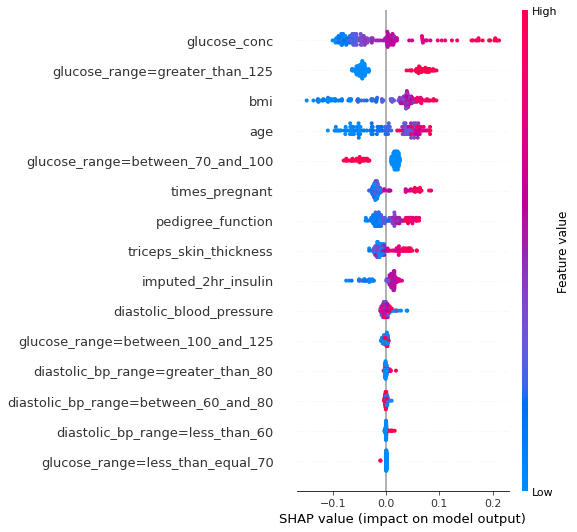

In [181]:
explain_model(best_rf, X_test)